In [1]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from algorithms.bisection import BisectionLearner
from algorithms.exp_weights import ExpWeights
from algorithms.exp_fast import ExpWeightsFast
from algorithms.ons import ONS
from algorithms.thompson_sampling import ThompsonSamplingLearner
from bandit import BanditProblem
from runner import Runner

np.random.seed(42)

n_basis = 100  # number of basis functions
B = 5.0  # budget on sum of weights
noise_sigma = 0.01  # noise standard deviation
horizon = 100  # number of time steps per trial
num_trials = 3  # number of independent trials
interval = [-1, 1]  # interval

prior_mu = np.random.uniform(0, 1, n_basis)
B_mu = np.random.uniform(0, 1) * B
prior_mu = prior_mu / np.sum(prior_mu) * B_mu
prior_Sigma = np.eye(n_basis) * 1.0

common_config = {
    "interval": interval,
    "prior_mu": prior_mu,
    "prior_Sigma": prior_Sigma,
    "B": B,
    "n_basis": n_basis,
    "noise_sigma": noise_sigma,
    "horizon": horizon,
}

learner_configs = [
    (
        ThompsonSamplingLearner,
        common_config
        | {
            "name": "ThompsonSampling",
            "burn_in": 500,
        },
    ),
    (
        BisectionLearner,
        common_config
        | {
            "name": "Bisection",
            "delta": 1 / np.sqrt(horizon),
            "confidence_const": 1,
        },
    ),
    (
        ExpWeights,
        common_config
        | {
            "name": "ExpWeights",
        },
    ),
    # (
    #     ExpWeightsFast,
    #     common_config
    #     | {
    #         "name": "ExpWeightsFast",
    #     },
    # ),
    (
        ONS,
        common_config
        | {
            "name": "ONS",
            "sigma": 1,
            "lambda_": 1 / 2,
            "eta": 1 / (5 * np.sqrt(horizon)),
            "epsilon": 1 / np.sqrt(horizon),
            "delta": 1 / np.sqrt(horizon),
            "C": 1,
        },
    ),
]

In [2]:
# Plotting tools
# Plot the true function


def phi(x, t):
    """Basis function: |x - t|."""
    return np.abs(x - t)


def f(x, w, interval):
    ts = np.linspace(interval[0], interval[1], len(w))
    x = np.atleast_1d(x)
    return np.sum(np.array([phi(x, t) for t in ts]).T * w, axis=1)


def plot(f_star, runner, name_of_the_plot, interval, precision=1000):
    sns.set_theme(style="ticks", context="paper", font_scale=1)
    n_learners = len(runner.learners)
    fig, axs = plt.subplots(1, n_learners, figsize=(5 * n_learners, 5), squeeze=False)
    fig.suptitle(name_of_the_plot)
    axs = axs[0]  # get the row of axes
    # x axis shows the domain of the function
    for ax in axs:
        ax.set_xlim(interval)
        ax.set_ylim([-0.1, B])
        ax.set_xlabel("x")
        ax.set_ylabel("f(x)")

    algo_names = list(runner.learners[0].keys())
    colors = [
        "blue",
        "orange",
        "green",
        "red",
        "purple",
        "brown",
        "pink",
        "gray",
        "olive",
        "cyan",
    ]

    for j in range(n_learners):
        ax = axs[j]
        xs = np.linspace(interval[0], interval[1], precision)

        # plot the true function
        y_true = [f_star(x_i) for x_i in xs]
        ax.plot(xs, y_true, label="True function", color="black", linewidth=2)

        for i in range(horizon):
            if i % 3 != 0:
                continue

            # plot Thompson Sampling's function estimates
            if "ThompsonSampling" in runner.learners[j]:
                ts = runner.learners[j]["ThompsonSampling"]
                ws = ts.ws[i]
                ys = f(xs, ws, interval)
                kwargs = {
                    "alpha": np.exp(0.01 * (i - horizon)),
                    "linestyle": ":",
                    "color": "black",
                }
                kwargs = (
                    kwargs | {"label": "TS-Sampled Functions"} if i == 0 else kwargs
                )
                ax.plot(xs, ys, **kwargs)

            for k, alg_name in enumerate(algo_names):
                learner = runner.learners[j][alg_name]
                action = learner.history_x[i]
                kwargs_0 = {
                    "color": colors[k],
                    "label": alg_name,
                    "edgecolor": "k",
                    "zorder": i,
                }
                kwargs_non_0 = {
                    "color": colors[k],
                    "alpha": np.exp(0.01 * (i - horizon)),
                    "s": 100 * np.exp(0.01 * (i - horizon)),
                    "edgecolor": "k",
                    "zorder": i,
                }
                ax.scatter(
                    action, f_star(action), **(kwargs_0 if i == 0 else kwargs_non_0)
                )
        ax.legend()

    plt.tight_layout()
    plt.show()

## Execution

In [ ]:
from utils import quadratic, absolute_value, linear

# QUADRATIC FUNCTION
m = 0.2
a = 4
quadratic = partial(quadratic, m=m, a=a)

bandit = BanditProblem(
    w_true=None, ts=None, sigma=noise_sigma, f_star=quadratic, interval=interval
)

quadratic_runner = Runner(None, learner_configs, horizon, num_trials, problem=bandit)
quadratic_runner.run()

# ABSOLUTE VALUE FUNCTION
m = 0.2
a = 4
absolute_value = partial(absolute_value, m=m, a=a)

bandit = BanditProblem(
    w_true=None, ts=None, sigma=noise_sigma, f_star=absolute_value, interval=interval
)

absolute_runner = Runner(None, learner_configs, horizon, num_trials, problem=bandit)
absolute_runner.run()

# LINEAR FUNCTION
m = -2
a = 1
linear = partial(linear, m=m, a=a)

bandit = BanditProblem(
    w_true=None, ts=None, sigma=noise_sigma, f_star=linear, interval=interval
)

linear_runner = Runner(None, learner_configs, horizon, num_trials, problem=bandit)
linear_runner.run()

Optimal action and value:  (np.float64(0.19919919919919926), np.float64(2.565127690252486e-06))
Optimal action and value:  (np.float64(0.19919919919919926), np.float64(2.565127690252486e-06))
Optimal action and value:  (np.float64(0.19919919919919926), np.float64(2.565127690252486e-06))
Trial 1/3, Time step 0/100, Learner ThompsonSampling, Regret: 0.1151856809696465
Trial 1/3, Time step 0/100, Learner Bisection, Regret: 1.9599974348723095
Trial 1/3, Time step 0/100, Learner ExpWeights, Regret: 0.35999743487230973
Trial 1/3, Time step 0/100, Learner ONS, Regret: 0.2756869301793701
Trial 2/3, Time step 0/100, Learner ThompsonSampling, Regret: 0.14424394033093632
Trial 2/3, Time step 0/100, Learner Bisection, Regret: 1.9599974348723095
Trial 3/3, Time step 0/100, Learner ThompsonSampling, Regret: 0.2121553779393437
Trial 3/3, Time step 0/100, Learner Bisection, Regret: 1.9599974348723095
Trial 2/3, Time step 0/100, Learner ExpWeights, Regret: 0.63999743487231
Trial 2/3, Time step 0/100, L

TypeError: Runner.__init__() got an unexpected keyword argument 'interval'

## Plots

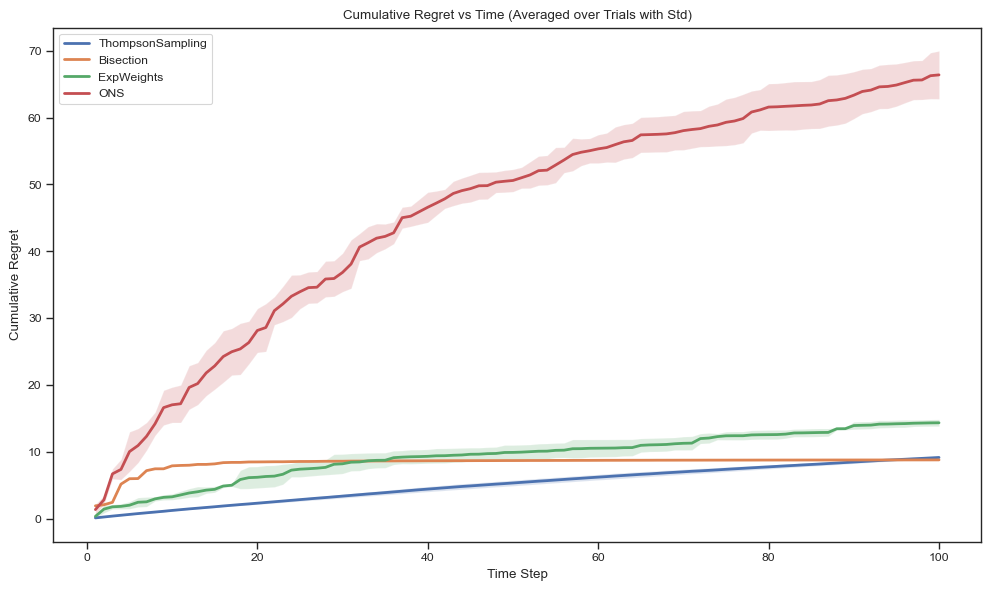

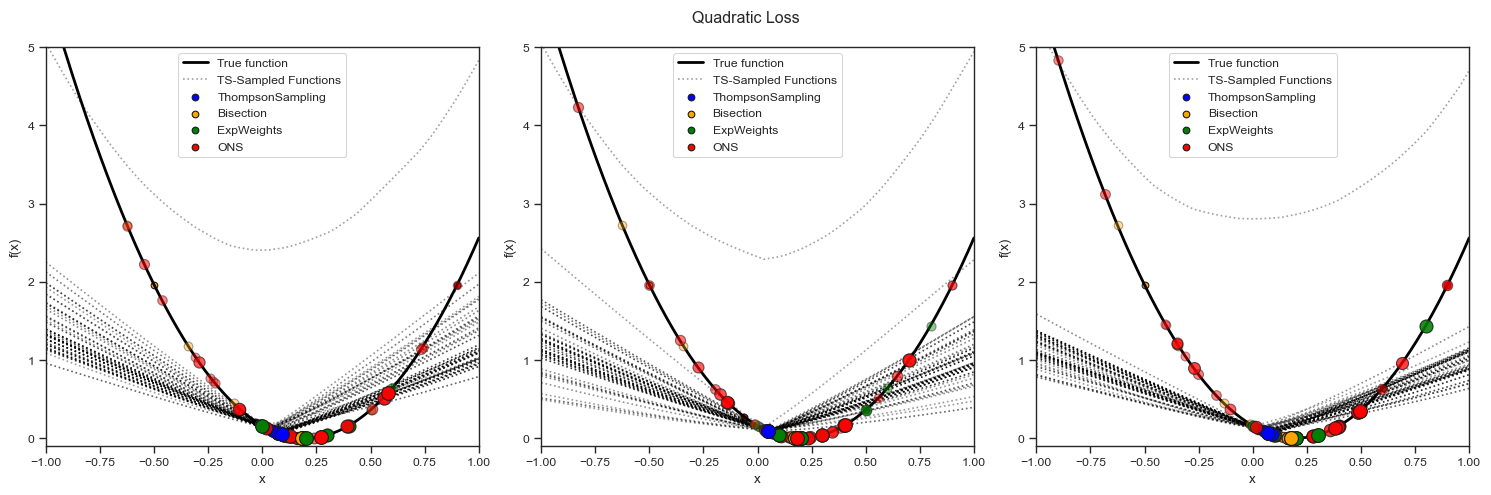

In [4]:
quadratic_runner.plot_regret()
plot(quadratic, quadratic_runner, "Quadratic Loss", interval)

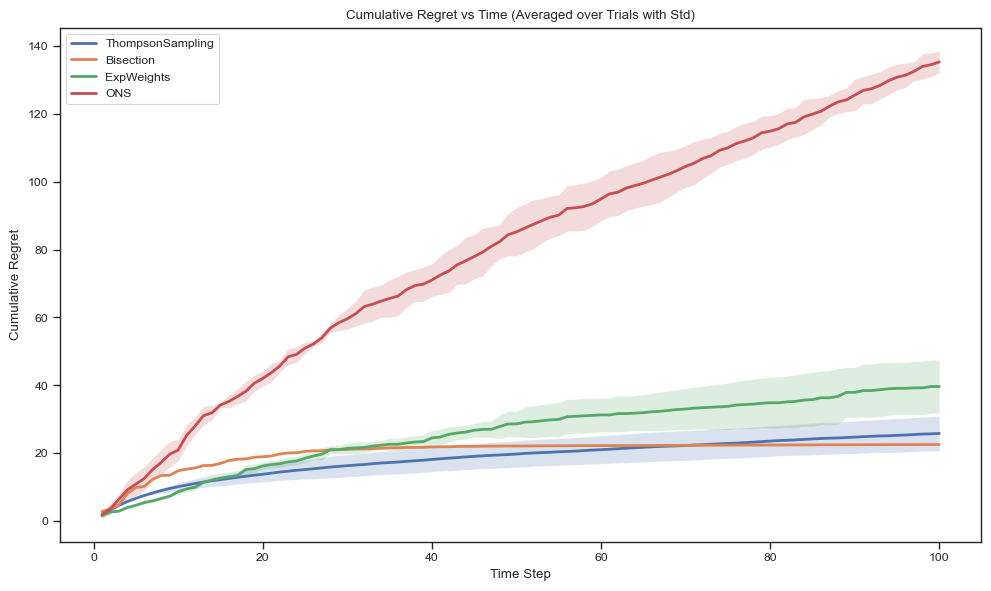

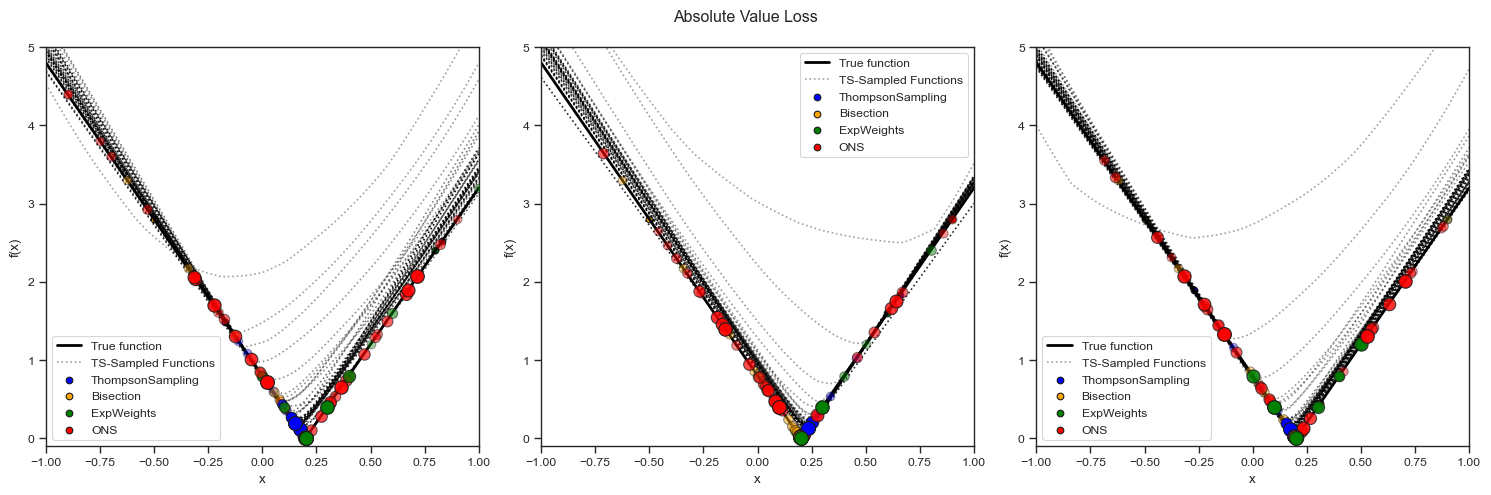

In [ ]:
absolute_runner.plot_regret()
plot(absolute_value, absolute_runner, "Absolute Value Loss", interval)

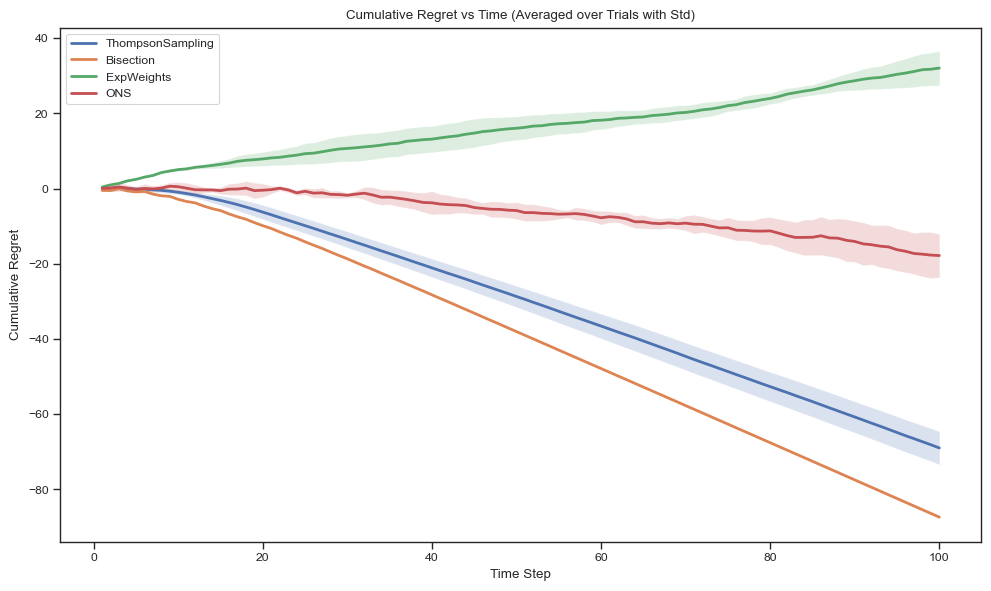

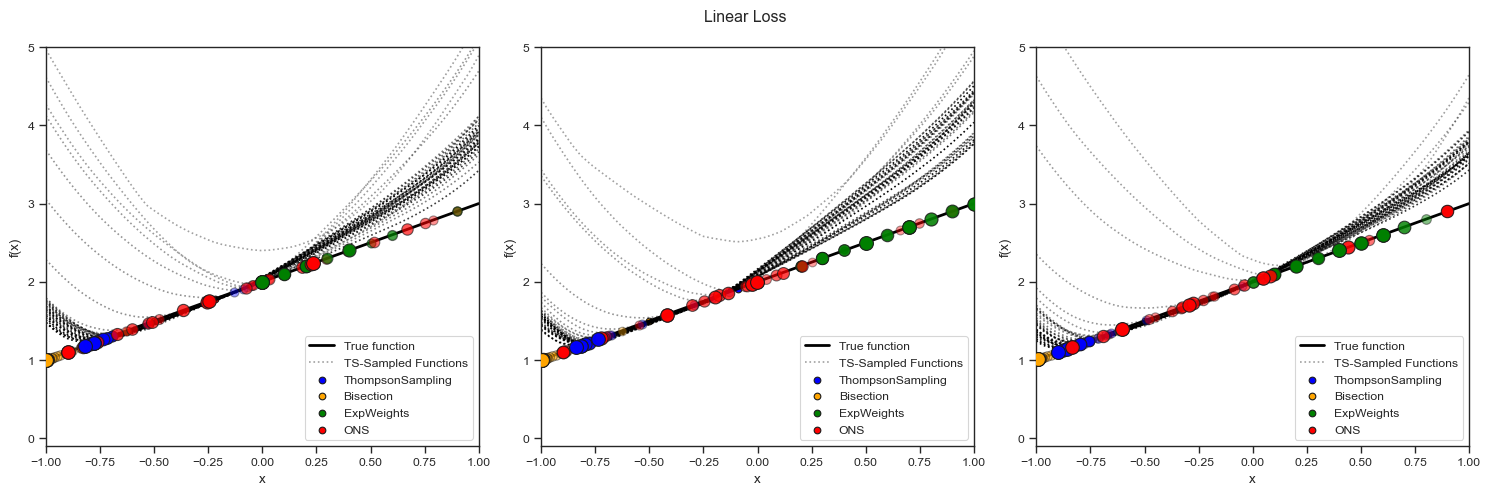

In [ ]:
linear_runner.plot_regret()
plot(linear, linear_runner, "Linear Loss", interval)